### Imports

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import OrderedDict
from pathlib import Path
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

### Device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Constants

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = 12
NUM_LAYERS = 3
NUM_EPOCHS = 10
DATA_DIR = Path('../data/dataset/')
LOOKBACK = 2.5
LOWEST_FREQUENCY = 50

### Load and split data

In [4]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)

In [5]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1']

In [6]:
X = pd.Series([run[0] for run in dataset], name='bag_name')
y = [run[1] for run in dataset]

In [7]:
le = LabelEncoder()
le.fit(y)
classes = le.classes_
num_classes = len(classes)
y = le.transform(y)
y = y.reshape(-1, 1)
lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)

In [8]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, stratify=y_training)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### Custom dataset

In [9]:
class SurfaceDataset(Dataset):
    def __init__(self, samples, labels, frequency=50, lookback=1):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
            frequency: The lowest frequency of collected data
            lookback: Size of window for prediction
        """

        self.samples = samples
        self.labels = labels
        self.frequency = frequency
        self.lookback = int(lookback * self.frequency)
        self.stride = int(300 / self.frequency)
        self.window_length = self.lookback * self.stride

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single, windowed time series from dataset
        """

        sample = self.samples[idx]
        run = pd.read_csv(sample, index_col=[0]).drop('Time', axis=1)
        initial_timestep = random.randint(0, (len(run) - 1) - self.window_length)
        final_timestep = initial_timestep + self.window_length
        timesteps = list(range(initial_timestep, final_timestep + self.stride, self.stride))
        
        X = run.iloc[timesteps].to_numpy()
        y = self.labels[idx]
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
    
train_dataloader = DataLoader(SurfaceDataset(X_train, y_train, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(SurfaceDataset(X_val, y_val, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(SurfaceDataset(X_test, y_test, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK), batch_size=1)

### Models

In [10]:
class LSTMSurfaceClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, hidden_size=256, num_layers=3):
        super(LSTMSurfaceClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.8)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output in the sequence for classification
        return out

# Define model
hidden_size = 100
lstm_model = LSTMSurfaceClassifier(input_size=INPUT_SIZE, output_size=num_classes, hidden_size=hidden_size, num_layers=NUM_LAYERS).to(device)

In [17]:
class CNNSurfaceClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, kernel_size=3, num_blocks=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.num_blocks = num_blocks
        
        self.model = nn.Sequential(
            nn.Conv1d(self.input_size, 128, self.kernel_size, stride=2),
            # nn.BatchNorm1d(self.input_size),
            # nn.MaxPool1d(self.kernel_size),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Conv1d(128, 256, self.kernel_size, stride=2),
            # nn.BatchNorm1d(self.input_size),
            # nn.MaxPool1d(self.kernel_size),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Conv1d(256, 512, self.kernel_size, stride=2),
            # nn.BatchNorm1d(self.input_size),
            # nn.MaxPool1d(self.kernel_size),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, self.output_size),
        )

    def forward(self, x):
        x = self.model(x)
        return self.fc(x)

kernel_size = int(LOOKBACK * LOWEST_FREQUENCY) // 10
if not kernel_size % 2:
    kernel_size += 1
cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=num_classes, kernel_size=kernel_size, num_blocks=NUM_LAYERS).to(device)

In [18]:
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNNSurfaceClassifier                     --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       20,096
│    └─ReLU: 2-2                         --
│    └─Conv1d: 2-3                       426,240
│    └─ReLU: 2-4                         --
│    └─Conv1d: 2-5                       1,704,448
│    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       30,730
Total params: 2,181,514
Trainable params: 2,181,514
Non-trainable params: 0

### Loss function

In [19]:
criterion = nn.CrossEntropyLoss()

### Optimizer

In [20]:
optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=1e-3,
    )
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Early stopping

In [21]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=1e-3)

### Training loop

In [25]:
train_batches = len(train_dataloader)
val_batches = len(val_dataloader)

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    pbar = tqdm(train_dataloader, total=train_batches)
    cnn_model.train()
    for idx, (batch_x, batch_y) in enumerate(pbar):
        optimizer.zero_grad()
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        train_outputs = cnn_model(batch_x)
        train_loss = criterion(train_outputs, batch_y)
        running_train_loss += train_loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
    scheduler.step()

    pbar_val = tqdm(val_dataloader, total=val_batches)
    cnn_model.eval()
    with torch.no_grad():
        for idx, (batch_x_val, batch_y_val) in enumerate(pbar_val):
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            batch_x_val = batch_x_val.permute(0, 2, 1)
            val_outputs = cnn_model(batch_x_val)
            val_loss = criterion(val_outputs, batch_y_val)
            running_val_loss += val_loss
            
            pbar_val.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
            
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_train_loss,
        'val_loss': running_val_loss,
    }, f"../data/checkpoints/cnn_classifier_{epoch + 1}.pt")

Epoch 10/10, Validation loss: 1.04E+00: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


### Test

In [26]:
test_batches = len(test_dataloader)
y_pred = []
running_test_loss = 0.0

pbar_test = tqdm(test_dataloader, total=test_batches)
cnn_model.eval()
with torch.no_grad():
    for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
        batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
        batch_x_test = batch_x_test.permute(0, 2, 1)
        test_outputs = cnn_model(batch_x_test)
        test_loss = criterion(test_outputs, batch_y_test)
        y_pred.append(torch.argmax(test_outputs).cpu().numpy())
        running_test_loss += test_loss
        
        pbar_test.set_description(f"Test loss: {running_test_loss / (idx + 1):.2E}")


Test loss: 1.11E+00: 100%|██████████| 335/335 [00:09<00:00, 36.08it/s]


                     precision    recall  f1-score   support

   10_Mata_ukladana       0.33      0.26      0.29        27
           1_Panele       0.58      0.84      0.69        95
2_Wykladzina_czarna       0.61      0.52      0.56        27
 3_Wykladzina_jasna       1.00      0.65      0.79        26
            4_Trawa       0.71      1.00      0.83        27
    5_Spienione_PCV       0.43      0.46      0.44        26
         6_Linoleum       0.67      0.23      0.34        26
    7_Plytki_w_sali       0.50      0.26      0.34        27
      8_Pusta_plyta       0.39      0.27      0.32        26
         9_podklady       0.45      0.46      0.46        28

           accuracy                           0.57       335
          macro avg       0.57      0.50      0.51       335
       weighted avg       0.57      0.57      0.54       335


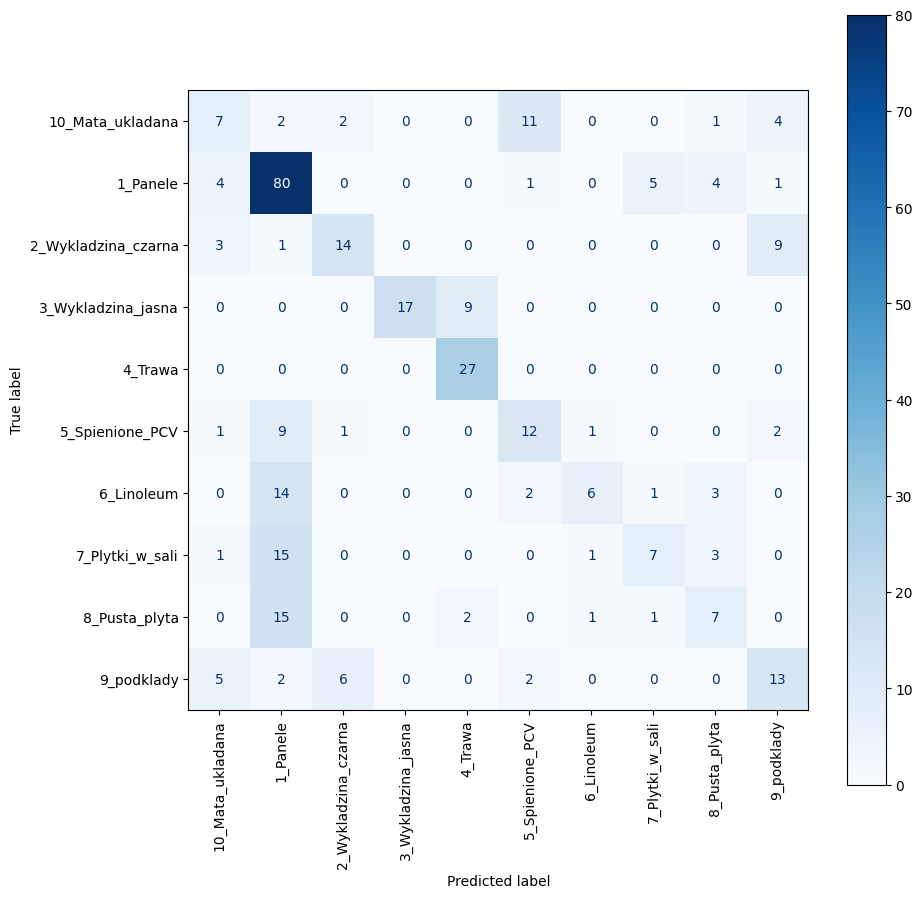

In [27]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

# y_test = lb.inverse_transform(y_test)
print(classification_report(y_test, y_pred, target_names=classes))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, xticks_rotation='vertical', cmap='Blues', ax=ax)